In [538]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [539]:
data = pd.read_csv('prepared_data_with_cuts.csv', index_col=0)

data.head(2)

,title_words,days_passed,ct_image,ct_tags,text,ct_words,title_emot_quotient,featured_in_tds,read_time,links,...,day_of_week,month,is_month_end,is_quarter_end,is_month_start,is_quarter_start,week_of_year,quarter,bullets_present,ct_links
3,6.0,6.0,8.0,78.0,[Clustering is a Machine Learning technique th...,2492.0,0.0,True,11.0,[],...,0,2,False,False,False,False,6,1,1,1
4,7.0,7.0,1.0,45.0,"[In the initial series post, we created a simp...",2367.0,0.0,False,10.0,[https://medium.com/@chris.moradi/building-pre...,...,6,2,False,False,False,False,5,1,1,4


In [541]:
features = ['title_words', 'days_passed', 'ct_image', 'ct_tags', 'ct_words',
       'title_emot_quotient', 'featured_in_tds', 'read_time',
       'img/word',  'text_sentiment', 'keyword_proportion', 'day', 'day_of_week', 'month', 
       'bullets_present', 'followedBy', 'following', 'ct_links', 'is_month_end', 'is_quarter_end', 'is_month_start', 'is_quarter_start',
       'week_of_year', 'quarter']

In [542]:
claps=pd.Series(data['claps'])

In [587]:
claps.quantile(.85)

754.2999999999997

In [ ]:
#### bin_data = pd.DataFrame([[0,0,150], [1,151,750], [2,751, claps.max()]])
bin_data.columns = ['bucket', 'start', 'end']

In [544]:
data['new_claps'] = 2
data['new_claps'] = data['claps'].apply(lambda x: 0 if x <=150 else 1 if (x > 150 and x <= 750) else 2)

In [545]:
bin_data

,bucket,start,end
0,0,0,150.0
1,1,151,750.0
2,2,751,2000.0


In [546]:
X = data[features]
y = data['new_claps']

In [547]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [548]:
X_train.shape, X_val.shape

((3391, 24), (848, 24))

In [588]:
data['new_claps'].value_counts()

0    1868
1    1730
2     641
Name: new_claps, dtype: int64

In [550]:
X_train.head()

,title_words,days_passed,ct_image,ct_tags,ct_words,title_emot_quotient,featured_in_tds,read_time,img/word,text_sentiment,...,bullets_present,followedBy,following,ct_links,is_month_end,is_quarter_end,is_month_start,is_quarter_start,week_of_year,quarter
2068,7.0,67.0,2.0,45.0,1416.0,0.0,False,7.0,0.001412,-0.9966,...,0,10983.0,3.0,24,False,False,False,False,49,4
601,10.0,224.0,2.0,47.0,882.0,0.0,True,5.0,0.002268,0.9961,...,1,1430.0,111.0,6,False,False,False,False,26,3
617,7.0,255.0,1.0,80.0,234.0,0.0,False,3.0,0.004274,-0.1655,...,1,139.0,194.0,1,False,False,True,False,22,2
4655,10.0,223.0,2.0,30.0,280.0,0.0,False,2.0,0.007143,0.7331,...,0,710.0,71.0,1,False,False,False,False,27,3
1986,8.0,54.0,1.0,48.0,76.0,0.0,False,5.0,0.013158,-0.1511,...,0,2461.0,1.0,2,False,False,False,False,51,4


In [551]:
rf = RandomForestClassifier()

In [655]:
grid = {'min_samples_leaf' : [3,5, 10, 15], 'max_features' : ['auto', 'log2', 'sqrt'], 'n_estimators':[100,200,300]
       }
clf = GridSearchCV(rf, grid, cv=5)
clf.fit(X_train, y_train)
clf.best_estimator_

In [512]:
rf = RandomForestClassifier(min_samples_leaf=5, max_features='auto', n_estimators=400, random_state=10)

rf.fit(X_train, y_train)
val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

In [ ]:
train_pred = rf.predict(X_train)

In [ ]:
log_loss(y_val, val_pred_probs, labels=rf.classes_)

In [ ]:
pd.Series(val_pred).value_counts()

In [ ]:
act_pred = pd.concat([pd.Series(list(y_val)), pd.Series(val_pred)], axis = 1)
act_pred.columns = ['actual_bin', 'predicted_bin']

act_pred.head()

bin_data['bucket'] = bin_data['bucket'].astype('uint8')
bin_data['start'] = bin_data['start'].astype('float32')
bin_data['end'] = bin_data['end'].astype('float32')


bin_data.info()

old_range = pd.DataFrame(bin_data.loc[np.array(act_pred.actual_bin),['start', 'end']])
old_range.reset_index(drop=True, inplace = True)
# old_range.head()
new_range = pd.DataFrame(bin_data.loc[np.array(act_pred.predicted_bin),['start', 'end']])
new_range.reset_index(drop=True, inplace = True)
new_range.head()

final_pred = pd.DataFrame(pd.concat([old_range, new_range], axis = 1))

final_pred = final_pred.set_index(X_val.index.values)
final_pred.columns = ['actual_start', 'actual_end', 'pred_start', 'pred_end']
# final_pred.head(50)

final_pred.loc[[4294, 3905, 1407, 2901, 3385, 4098, 2168, 479]]

In [460]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:10]

,Importance
days_passed,0.112793
followedBy,0.104345
keyword_proportion,0.075599
following,0.067840
img/word,0.067047
week_of_year,0.064149
ct_words,0.063081
text_sentiment,0.059782
ct_tags,0.057935
day,0.047270


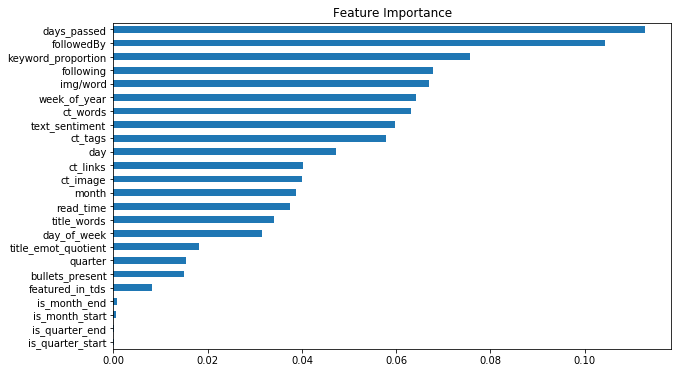

In [461]:

fi.sort_values(by = 'Importance', ascending=True).plot.barh(figsize = (10,6), legend = False, title = 'Feature Importance')


In [574]:
rf = RandomForestClassifier(min_samples_leaf=2, max_features='auto', n_estimators=100, random_state=10)
rf.fit(X_train, y_train)
val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

Confusion matrix
[[247 137   1]
 [124 215   7]
 [ 15  92  10]]


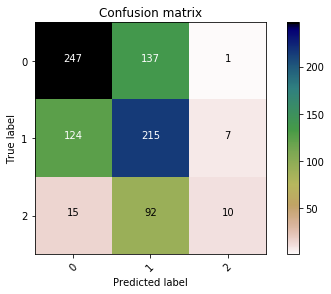

In [575]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [590]:
y_train.value_counts()

0    1483
1    1384
2     524
Name: new_claps, dtype: int64

In [591]:
y_val.value_counts()

0    385
1    346
2    117
Name: new_claps, dtype: int64

In [594]:
pd.Series(val_pred).value_counts()

1    444
0    386
2     18
dtype: int64